In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/Cardiac\ Project/Registration_phase/based\ on\ doc2

/content/drive/MyDrive/Cardiac Project/Registration_phase/based on doc2


In [24]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils import data
from torchvision import transforms
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
#https://github.com/saoalo/text-generation

In [6]:
def preprocess_mask(mask):
    new_mask = np.zeros((64, 64))
    mask = np.where(mask>101 , mask , 0)
    mask = np.where(mask !=0 , 1 , 0)
    return mask

In [38]:
def read_a_patient_data(main_path):
    folder_nums = os.listdir(main_path)
    folder_nums = [f for f in folder_nums if len(f) == 1]
    dataset = []
    for folder_num in folder_nums:
        folder_path = main_path + "/" + folder_num
        files_in_folder_num = os.listdir(folder_path)
        if "cine_seri" not in files_in_folder_num:
                continue
        for file_in_folder_num in files_in_folder_num:
            seri_mask_dataset = []
            if "cine_seri" in file_in_folder_num:
                f_dataset = []
                cine_seri_folder = folder_path+"/"+file_in_folder_num
                images = os.listdir(cine_seri_folder)
                images = sorted(images)
                print(cine_seri_folder , len(images))

                for image_name in images:
                    image_path = cine_seri_folder + "/" + image_name
                    image = cv2.imread(image_path , cv2.IMREAD_GRAYSCALE)
                    image = image/255
                    image = image.astype("float")
                    image = transforms.ToTensor()(image)
                    image = image.reshape(-1)
                    f_dataset.append(image)
            if "results" in file_in_folder_num:
                mask_path = folder_path+"/"+file_in_folder_num
                fs_in_results = os.listdir(mask_path)
                for f in fs_in_results:
                    if "rigid_mask" in f:
                        this_mask_path = mask_path + "/" + f
                        mask = cv2.imread(this_mask_path , cv2.IMREAD_GRAYSCALE)
                        mask = preprocess_mask(mask)
                        mask = mask.reshape(-1)
        f_dataset = torch.stack(f_dataset) 
        dataset.append((f_dataset , mask))      
    return dataset

In [40]:
dataset = []
for ok in ['ok1,2']:
    ok_path = "dataset/" + ok + '/' 
    patient_ids = os.listdir(ok_path)
    for patient_id in patient_ids:
        patient_path = ok_path + patient_id
        print(patient_path)
        patient_data = read_a_patient_data(patient_path)
        print("----------------------------")
        dataset.append(patient_data)

dataset/ok1,2/423841
dataset/ok1,2/423841/1/cine_seri 25
dataset/ok1,2/423841/2/cine_seri 25
dataset/ok1,2/423841/3/cine_seri 25
dataset/ok1,2/423841/4/cine_seri 25
----------------------------
dataset/ok1,2/746603
dataset/ok1,2/746603/4/cine_seri 25
dataset/ok1,2/746603/5/cine_seri 25
dataset/ok1,2/746603/6/cine_seri 25
dataset/ok1,2/746603/7/cine_seri 25
----------------------------
dataset/ok1,2/928508
dataset/ok1,2/928508/7/cine_seri 25
dataset/ok1,2/928508/3/cine_seri 25
dataset/ok1,2/928508/5/cine_seri 25
dataset/ok1,2/928508/4/cine_seri 25
----------------------------
dataset/ok1,2/1136533
dataset/ok1,2/1136533/2/cine_seri 25
dataset/ok1,2/1136533/3/cine_seri 25
dataset/ok1,2/1136533/4/cine_seri 25
dataset/ok1,2/1136533/5/cine_seri 25
----------------------------
dataset/ok1,2/1216198
dataset/ok1,2/1216198/2/cine_seri 25
dataset/ok1,2/1216198/1/cine_seri 25
dataset/ok1,2/1216198/3/cine_seri 25
dataset/ok1,2/1216198/4/cine_seri 25
----------------------------
dataset/ok1,2/124759

In [41]:
dataset = [item for sublist in dataset for item in sublist]

In [42]:
len(dataset)

86

In [119]:
train_dataset , test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

In [120]:
print(len(train_dataset) , len(test_dataset))

68 18


In [142]:
train_loader = data.DataLoader(train_dataset ,batch_size = 8 , shuffle=True ) 
test_loader = data.DataLoader(test_dataset ,batch_size = 8 , shuffle=True) 

In [143]:
class LSTMGenerator(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMGenerator , self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers , batch_first = True)
        self.create_mask = nn.Linear(self.hidden_size, input_size)
    
    def zero_state(self, batch_size):
        h = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return (h, c)

    def forward(self, x , state):
        x = x.float().to(device)
        lstm_out, state = self.lstm(x,(state[0].to(device) , state[1].to(device)))

        mask = self.create_mask(lstm_out)
        return mask,state

In [144]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [145]:
def train(model , train_loader):    
    all_loss= []
    for i in range(num_epochs):
        model.train()
        epoch_loss = 0

        for cine_seri, masks in train_loader:
            # set gradients to zero
            optimizer.zero_grad()

            cine_seri.float().to(device)
            masks = masks.to(device)
            
            # initial LSTM stage
            state_h, state_c = model.zero_state(cine_seri.shape[0])
            state_h, state_c = state_h.to(device), state_c.to(device)

            # Train
            pred, (state_h, state_c) = model(cine_seri, (state_h, state_c))
            pred_masks = pred[: , -1 , :]
            loss = dice_loss(pred_masks , masks )
            # Perform back-propagation
            loss.backward()
            
            # perform gradient clipping to prevent gradients from exploding
            #_ = torch.nn.utils.clip_grad_norm_(model.parameters(), 2)

            # Update the network's parameters
            optimizer.step()
            epoch_loss += loss
            all_loss.append(epoch_loss)
        if i%100 == 0:
            print(f"epoch: {i + 1} loss: {epoch_loss}")
        #save_model(model,path=os.path.join(default.WEIGHTS_PATH,f"bootstrap_epoch({i+1+init_trained})_loss({loss}).pth"))
    plt.plot(range(len(all_loss)) , all_loss)
    return model

In [146]:
input_size = 4096
sequence_length = 25
num_layers = 1
hidden_size = 500
num_epochs = 500
learning_rate = 0.001

In [147]:
model = LSTMGenerator(input_size, hidden_size, num_layers)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
dice_loss = DiceLoss().to(device)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch: 1 loss: 8.181442260742188
epoch: 101 loss: 6.405265808105469
epoch: 201 loss: 5.863402366638184
epoch: 301 loss: 5.410660743713379
epoch: 401 loss: 4.646553039550781


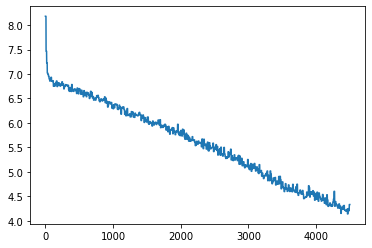

In [ ]:
model = train(model, train_loader)

In [97]:
def test(model , test_loader):
    with torch.no_grad():
        all_loss = 0
        d = []
        for cine_seri, masks in test_loader:
            cine_seri = cine_seri.to(device)
            masks = masks.to(device)
            
            # initial LSTM stage
            state_h, state_c = model.zero_state(cine_seri.shape[0])
            state_h, state_c = state_h.to(device), state_c.to(device)

            # Train
            pred, (state_h, state_c) = model(cine_seri, (state_h, state_c))
            pred_masks = pred[: , -1 , :]
            loss = dice_loss(pred_masks , masks )
            all_loss += loss
            
        print(all_loss/len(test_loader.dataset)) 
    return masks , pred_masks

In [98]:
masks , pred_masks = test(model , test_loader)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


RuntimeError: ignored

In [ ]:
masks.shape

torch.Size([4, 4096])

In [ ]:
pred_masks.shape

torch.Size([4, 4096])

In [ ]:
this_masks = masks[3].cpu().numpy().reshape((64,64))

In [ ]:
this_pred = pred_masks[3].cpu().numpy().reshape((64,64))

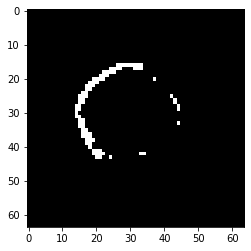

In [ ]:
plt.imshow(this_masks , cmap = 'gray')

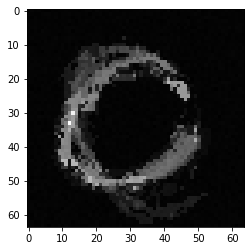

In [ ]:
plt.imshow(this_pred , cmap = 'gray')